<a href="https://colab.research.google.com/github/hy30n80/KERC2022/blob/main/Model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash



--2022-09-19 02:58:25--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-09-19 02:58:26--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5d853bbbf4522573e2e48c7d24.dl.dropboxusercontent.com/cd/0/get/BtNC6i6VXvsyOhneVXP4zmLudmzd1ti-znSAckXOSwtBwDOicaZWeXcSeg1y5B-OnDhjPcVtt9Vcv_AhRad1WosjVaVXwCKsBoi4bvSu81szOGD_-5WS-VGVXm6iSYj5ngu4XcTSHpXLO0uwHVgw2pcCgJIKx3OnFz03bifEQpmKeV1jafv14hEV37P3zmvVfZE/file?dl=1# [following]
--2022-09-19 02:58:26--  https://uc5d853bbbf4522573e2e48c7d24.dl.dropboxusercontent.com/cd/0/get/BtNC6i6VXvsy

In [10]:
from google.colab import drive
drive.mount('/content/drive')

from konlpy.tag import Okt, Mecab
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm
from tensorflow.keras.layers import(Input, Dense, Bidirectional, LSTM, Concatenate, concatenate, Embedding, Dropout)
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import sklearn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_x_path = './drive/MyDrive/KERC2022/KERC22Dataset_PublicTest/train_data.tsv'
train_y_path = './drive/MyDrive/KERC2022/KERC22Dataset_PublicTest/train_labels.csv'

In [4]:
EMBEDDING_DIM=100
MAXLEN = 30
TRUNCATING = 'post'
PADDING = 'pre'
OOV_TOKEN = '<OOV>'
NUM_WORDS = 15000
SPLIT_SIZE = 0.9

In [5]:
train_data = pd.read_csv(train_x_path, sep='\t')
labels = pd.read_csv(train_y_path)
#label csv 를 train_data에 병합
train_data['label'] = labels['label']
print(train_data[:5])
print(len(train_data))
print(train_data.isnull().sum())

   sentence_id person                                           sentence  \
0            1     어영  야! 전화 받아. 아무리 바빠도 내전화는 받아야 되는거 아냐? 약속 하나도 못지키는...   
1            2     어영     우리 아무래도 안되겠다. 이게 최선인거 같애. 평생 잊지 않을게. 행복하길 바란다.   
2            3    지구대                          김경사님, 아직 안가셨어요? 시간 다됐을텐데.   
3            4     순경                                         근무중인데 어딜가?   
4            5    지구대    다녀오세요. 이런날은 무조건 가서 축하해주셔야죠. 이순경이 대신 근무선다고 나온대요.   

   scene                                          context      label  
0  S0104                                              NaN  dysphoria  
1  S0108         포기한듯 탁 일어서는데, 띵동 문자. 후다닥 보는 어영. 기막혀 읽어보는  dysphoria  
2  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대    neutral  
3  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대  dysphoria  
4  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대   euphoria  
7339
sentence_id       0
person            0
sentence          0
scene             0
context        2017
label       

In [6]:
#context null 값 '결측' 으로 채우기
train_data['context'].fillna('결측', inplace=True)
print(train_data.isnull().sum())

sentence_id    0
person         0
sentence       0
scene          0
context        0
label          0
dtype: int64


In [8]:
# person, scene category 변형
train_data['person'].value_counts()
train_data['scene'].value_counts()


train_data['person'] = train_data['person'].astype('category')
train_data['scene'] = train_data['scene'].astype('category')


train_data['person']= train_data['person'].cat.codes
train_data['scene']= train_data['scene'].cat.codes
print(train_data[:5])

   sentence_id  person                                           sentence  \
0            1      42  야! 전화 받아. 아무리 바빠도 내전화는 받아야 되는거 아냐? 약속 하나도 못지키는...   
1            2      42     우리 아무래도 안되겠다. 이게 최선인거 같애. 평생 잊지 않을게. 행복하길 바란다.   
2            3      69                          김경사님, 아직 안가셨어요? 시간 다됐을텐데.   
3            4      36                                         근무중인데 어딜가?   
4            5      69    다녀오세요. 이런날은 무조건 가서 축하해주셔야죠. 이순경이 대신 근무선다고 나온대요.   

   scene                                          context      label  
0      0                                               결측  dysphoria  
1      1         포기한듯 탁 일어서는데, 띵동 문자. 후다닥 보는 어영. 기막혀 읽어보는  dysphoria  
2      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대    neutral  
3      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대  dysphoria  
4      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대   euphoria  


In [9]:
#전체 data 셔플

train_data=sklearn.utils.shuffle(train_data)
print(train_data)


      sentence_id  person                                           sentence  \
858          1445      55                     지금 그게 문제가 아니지. 여기 이러구 있으니까 좋아?   
6790        11333      42                              약속했다? 근데 자기혼자 결정해도 돼?   
3031         5188      23                   그런 연애할려면 때래쳐. 너무 아픈 사랑은 사랑이 아니래.   
2777         4691      46                                      아냐. 바로 들어갈거야.   
7154        11979      21                               아, 아니다. 이거 부영이 갖다 줘.   
...           ...     ...                                                ...   
2743         4643      46                    그럼 찜질방을 연말까지 정리해야 돼요. 어떡해요 사장님?   
1933         3267       1                                        찬물도 순서가 있어.   
5424         8999       5  집구석에서 편하게 자빠진 애가 이런걸 뭐하러 먹어? 나도 안먹는데. 나가서 고생하는...   
3529         5906       5  그거하고 이거하고 같애? 나이가 서른이나 됐으면 그정도는 눈치껏 해야지. 난 내아들...   
3662         6117      36                             예에. 손에 들고 계신거 전화 아닙니까?   

      scene                            

In [11]:
# Stopwords 는 우선 고려하지 않고 실행
# sentence , context 문자열 데이터로 처리
hannanum = Hannanum()
kkma = Kkma()
komoran = Komoran()
okt = Okt()
mecab = Mecab()

tok_sentences = []
for sen in tqdm(train_data['sentence']):
  tok_sen = mecab.morphs(sen)
  tok_sentences.append(tok_sen)

tok_contexts = []
for con in tqdm(train_data['context']):
  tok_con = mecab.morphs(con)
  tok_contexts.append(tok_con)

100%|██████████| 7339/7339 [00:00<00:00, 10568.37it/s]


[['지금', '그게', '문제', '가', '아니', '지', '.', '여기', '이러', '구', '있', '으니까', '좋', '아', '?'], ['약속', '했', '다', '?', '근데', '자기', '혼자', '결정', '해도', '돼', '?'], ['그런', '연애', '할려면', '때', '래', '쳐', '.', '너무', '아픈', '사랑', '은', '사랑', '이', '아니', '래', '.'], ['아냐', '.', '바로', '들어갈', '거', '야', '.'], ['아', ',', '아니', '다', '.', '이거', '부영', '이', '갖', '다', '줘', '.']]
문장 최대 길이:  81
문장 평균 길이:  15.150837988826815


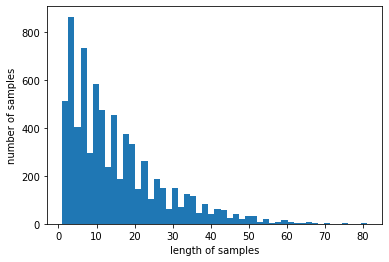

문맥 최대 길이:  2
문맥 평균 길이:  12.907344324839896


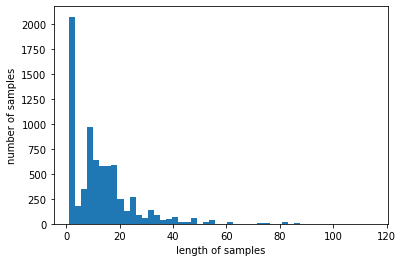

In [12]:
print(tok_sentences[:5])

print('문장 최대 길이: ', max(len(sen) for sen in tok_sentences))
print('문장 평균 길이: ', sum(map(len, tok_sentences))/len(tok_sentences))
plt.hist([len(sen) for sen in tok_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('문맥 최대 길이: ', max(len(con) for sen in tok_contexts))
print('문맥 평균 길이: ', sum(map(len, tok_contexts))/len(tok_contexts))
plt.hist([len(con) for con in tok_contexts], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()



In [13]:
# sentence, context 각각 tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def fit_and_seq(train_sentences, oov_token, maxlen, padding, truncating):
  
  tokenizer = Tokenizer(oov_token = oov_token)
  tokenizer.fit_on_texts(train_sentences)
  
  sequences= tokenizer.texts_to_sequences(train_sentences)
  pad_trunc_sequences= pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)

  return pad_trunc_sequences, tokenizer

"""
def tokenize_label(labels):

  label_tokenizer = Tokenizer()
  label_tokenizer.fit_on_texts(labels)

  label_seq = label_tokenizer.texts_to_sequences(labels)
  label_seq_np = np.array(label_seq)-1

  return label_seq_np, label_tokenizer
"""


'\ndef tokenize_label(labels):\n\n  label_tokenizer = Tokenizer()\n  label_tokenizer.fit_on_texts(labels)\n\n  label_seq = label_tokenizer.texts_to_sequences(labels)\n  label_seq_np = np.array(label_seq)-1\n\n  return label_seq_np, label_tokenizer\n'

In [14]:
train_sentence_seq, tokenizer = fit_and_seq(tok_sentences, OOV_TOKEN, MAXLEN, PADDING, TRUNCATING)
train_context_seq, _ = fit_and_seq(tok_contexts, OOV_TOKEN, MAXLEN, PADDING, TRUNCATING)

In [15]:
word_index = tokenizer.word_index
print(train_sentence_seq[3])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  177    2  185 1390   14
   24    2]


In [14]:
""" 
train_label_seq, label_tokenizer = tokenize_label(np.array(labels['label']))
label_word_index = label_tokenizer.word_index
print(train_label_seq[1])
print(label_word_index)
"""

" \ntrain_label_seq, label_tokenizer = tokenize_label(np.array(labels['label']))\nlabel_word_index = label_tokenizer.word_index\nprint(train_label_seq[1])\nprint(label_word_index)\n"

In [21]:
#label 값 0,1,2 로 Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le = le.fit(train_data['label'])

train_label_seq = le.transform(train_data['label'])
print(le.classes_)
print(train_data['label'][:10])
print(train_label_seq[:10])

#dysphoria:0, euphoria:1, neutral:2

['dysphoria' 'euphoria' 'neutral']
858     dysphoria
6790     euphoria
3031    dysphoria
2777      neutral
7154     euphoria
5161    dysphoria
1717      neutral
7074    dysphoria
5870     euphoria
1763    dysphoria
Name: label, dtype: object
[0 1 0 2 1 0 2 0 1 0]


In [16]:
"""
def train_val_split(sentences, labels, training_split):

  train_size = int(len(sentences)*training_split)

  train_sentences = sentences[:train_size]
  train_labels = labels[:train_size]


  val_sentences = sentences[train_size:]
  val_labels = labels[train_size:]

  return train_sentences, train_labels, val_sentences, val_labels
"""

'\ndef train_val_split(sentences, labels, training_split):\n\n  train_size = int(len(sentences)*training_split)\n\n  train_sentences = sentences[:train_size]\n  train_labels = labels[:train_size]\n\n\n  val_sentences = sentences[train_size:]\n  val_labels = labels[train_size:]\n\n  return train_sentences, train_labels, val_sentences, val_labels\n'

In [22]:
print(type(np.array(train_data['person'])), type(train_sentence_seq),type(train_context_seq), type(train_data['scene']) )

print(np.array(train_data['person']).shape)
print(train_sentence_seq.shape)
print(np.array(train_data['person']))
print(train_sentence_seq)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
(7339,)
(7339, 30)
[55 42 23 ...  5  5 36]
[[  0   0   0 ...  54  29   3]
 [  0   0   0 ... 220 124   3]
 [  0   0   0 ...  46 317   2]
 ...
 [637  81 665 ...   4  47 623]
 [211 249 157 ... 761  13   2]
 [  0   0   0 ... 210 765   3]]


In [23]:
#Data split 
from sklearn.model_selection import train_test_split
train_sentences, test_sentences = train_test_split(train_sentence_seq, test_size=0.1, shuffle=False)
train_contexts, test_contexts = train_test_split(train_context_seq, test_size=0.1, shuffle=False)
train_people, test_people = train_test_split(np.array(train_data['person']), test_size=0.1, shuffle=False)
train_scenes, test_scenes = train_test_split(np.array(train_data['scene']), test_size=0.1, shuffle=False)
train_labels, test_labels = train_test_split(train_label_seq, test_size=0.1, shuffle=False)

In [24]:

print(train_sentences.shape)
print(train_contexts.shape)
print(train_people.shape)
print(train_scenes.shape)
print(train_labels.shape)

print(test_sentences.shape)
print(test_contexts.shape)
print(test_people.shape)
print(test_scenes.shape)
print(test_labels.shape)



(6605, 30)
(6605, 30)
(6605,)
(6605,)
(6605,)
(734, 30)
(734, 30)
(734,)
(734,)
(734,)


In [25]:
def create_model(num_words, embedding_dim, maxlen):
  

  input_P = Input(shape=[1], name = "input_person")
  input_S = Input(shape=[1], name = "input_scene")
  input_sen = Input(shape=[30], name = "input_sentence")
  input_con = Input(shape=[30], name = "input_context")

  Dense_p1 = Dense(8, activation = 'relu')(input_P)
  Dense_p2 = Dense(1, activation = 'sigmoid')(Dense_p1)

  Dense_s1 = Dense(8, activation = 'relu')(input_S)
  Dense_s2 = Dense(1, activation = 'sigmoid')(Dense_s1)

  Embedding1 = Embedding(num_words, embedding_dim, input_length=maxlen)(input_sen)
  LSTM_sen = Bidirectional(LSTM(16, return_sequences=False))(Embedding1)
  Dense_sen = Dense(16, activation = 'sigmoid')(LSTM_sen)

  Embedding2 = Embedding(num_words, embedding_dim, input_length=maxlen)(input_con)
  LSTM_con = Bidirectional(LSTM(16, return_sequences=False))(Embedding2)
  Dense_con = Dense(16, activation = 'sigmoid')(LSTM_con)

  
  concat = concatenate([Dense_p2, Dense_s2, Dense_sen, Dense_con], name='concat')
  Drp1 = Dropout(0.3)(concat)
  Dense1 = Dense(16, activation = 'relu')(concat)
  Dense2 = Dense(8, activation = 'relu')(Dense1)
  Drp2 = Dropout(0.3)(Dense2)
  output = Dense(3, activation = 'softmax')(Dense2)


  model = tf.keras.Model(inputs =[input_P, input_S, input_sen, input_con], outputs=[output])


  return model


In [26]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentence (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 input_context (InputLayer)     [(None, 30)]         0           []                               
                                                                                                  
 input_person (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 input_scene (InputLayer)       [(None, 1)]          0           []                               
                                                                                              

In [28]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4*10**(epoch/10))
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)


In [29]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit((train_people, train_scenes, train_sentences, train_contexts), train_labels, epochs=30, 
                    validation_data = ((test_people, test_scenes, test_sentences, test_contexts), test_labels), callbacks=[lr_schedule])

Epoch 1/30
207/207 [==============================] - 52s 124ms/step - loss: 1.1666 - accuracy: 0.1991 - val_loss: 1.0450 - val_accuracy: 0.5450 - lr: 1.0000e-04
Epoch 2/30
207/207 [==============================] - 22s 107ms/step - loss: 0.9569 - accuracy: 0.6124 - val_loss: 0.8735 - val_accuracy: 0.6308 - lr: 1.2589e-04
Epoch 3/30
207/207 [==============================] - 22s 105ms/step - loss: 0.8973 - accuracy: 0.6151 - val_loss: 0.8546 - val_accuracy: 0.6308 - lr: 1.5849e-04
Epoch 4/30
207/207 [==============================] - 22s 107ms/step - loss: 0.8688 - accuracy: 0.6164 - val_loss: 0.8365 - val_accuracy: 0.6322 - lr: 1.9953e-04
Epoch 5/30
207/207 [==============================] - 21s 102ms/step - loss: 0.7977 - accuracy: 0.6341 - val_loss: 0.7717 - val_accuracy: 0.6322 - lr: 2.5119e-04
Epoch 6/30
207/207 [==============================] - 22s 104ms/step - loss: 0.7164 - accuracy: 0.6571 - val_loss: 0.7458 - val_accuracy: 0.6226 - lr: 3.1623e-04
Epoch 7/30
207/207 [========

In [26]:
result = model.predict((train_people, train_scenes, train_sentences, train_contexts))
predict = tf.argmax(result, axis=1)
print(predict)

tf.Tensor([1 0 1 ... 0 0 0], shape=(6605,), dtype=int64)
